# Interpolação

In [20]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from typing import Sequence, List
import math
from interpolacao import linear_partes

## Interpolação Linear por Partes

In [21]:
from typing import Optional, TypeAlias

Vetor: TypeAlias = list[float]

def interpolacao_linear(
    a: Vetor,
    b: Vetor,
    x:Optional[float] = None,
    t:Optional[float] = None
    ) -> float | Vetor:
    """
    Realiza interpolação linear entre dois pontos em Rⁿ.

    A método permite dois modos de uso:
        - Modo cartesiano (R²): o usuário fornece um valor 'x' intermediário entre
        as abscissas de 'a' e 'b', e a função retorna o valor interpolado de 'y';
        - Modo paramétrico (Rⁿ): o usuário fornece um parâmetro 't' ∈ [0, 1],
        e a função retorna o ponto interpolado entre 'a' e 'b' em qualquer dimensão.

    Args:
        a : list[float]
            Primeiro ponto (vetor em Rⁿ).
        b : list[float]
            Segundo ponto (mesma dimensão de 'a').
        x : float, optional
            Valor da variável independente (somente em R²). Deve estar dentro
            do intervalo [xₐ, x_b].
        t : float, optional
            Parâmetro de interpolação ∈ [0, 1]. Usado para o modo paramétrico.

    Returns:
        float | list[float]
            - Se 'x' é fornecido, retorna o valor interpolado de 'y(x)' (float);
            - Se 't' é fornecido, retorna o vetor interpolado 'p(t)' (list[float]).

    Raises:
        ValueError
            - Se 'a' e 'b' têm dimensões diferentes;
            - Se nenhum ou ambos os parâmetros ('x', 't') são fornecidos;
            - Se 'x' é usado fora do intervalo definido por 'a' e 'b';
            - Se 'x' é usado com vetores que não pertencem a R²;
            - Se 't' não está no intervalo [0, 1].
    """
    vetor = []
    if len(a) != len(b):
        raise ValueError(f"Os pontos devem ser de mesma dimensão")
    
    if x is None and t is None:
        raise ValueError('Algum dos parâmetros deve ser passado (x ou t).')
    
    if x is not None and t is not None:
        raise ValueError('Apenas um dos parâmetros deve ser passado (x ou t).')
    
    if x is not None:
        if a[0] == a[1]:
            raise ValueError(f'Pontos consecutivos com mesmo x = {a[0]} geram um segmento vertical: interpolação indefinida.')
        if len(a) != 2 or len(b) != 2:
            raise ValueError('Interpolação por x só é válida para vetores no R2')
        x_min, x_max = sorted([a[0], b[0]])
        if not x_min <= x <= x_max:
            raise ValueError(f"x={x} está fora do intervalo [{x_min}, {x_max}].")
        return a[1] + (b[1] - a[1])/(b[0] - a[0]) * (x - a[0])
        
    if t is not None: 
        if not 0 <= t <= 1:
            raise ValueError('t deve estar entre 0 e 1.')
        for coords1, coords2 in zip(a, b): 
            vetor.append((1-t) * coords1 + t * coords2)
        return vetor


In [22]:

def plot_interpolacao_linear(
        x_valores: Sequence[float],
        y_valores: Sequence[float],
        x: float = None
    ) -> tuple[plt.figure, plt.axes]:
    """
    Plota a interpolação linear por partes entre um conjunto de pontos em R².

    A função conecta cada par consecutivo de pontos (xᵢ, yᵢ) por segmentos de reta,
    exibindo a interpolação linear por partes. Opcionalmente, pode destacar o ponto
    interpolado correspondente a um valor específico de 'x'.

    Args:
        x_valores (Sequence[float]): 
            Valores da variável independente.
        y_valores (Sequence[float]): 
            Valores correspondentes da variável dependente.
        x (float, optional): 
            Valor da variável independente onde se deseja destacar o ponto interpolado.
            Caso não seja fornecido, o gráfico exibirá apenas a interpolação.

    Returns:
        Tuple[plt.Figure, plt.Axes]:
            Um par contendo:
              - 'Figure': objeto da figura criada;
              - 'Axes': objeto dos eixos do gráfico.

    Raises:
        ValueError: 
            - Se as listas 'x_valores' e 'y_valores' tiverem comprimentos diferentes.
            - Se houver menos de dois pontos para interpolar.
            - Se 'x' estiver fora do intervalo de 'x_valores'.
    """

    pontos = sorted(zip(x_valores, y_valores), key = lambda p: p[0])
    x_sorted, y_sorted = zip(*pontos)

    fig, ax = plt.subplots()
    x_vals = np.linspace(x_sorted[0], x_sorted[-1], 100)
    interpolador_por_partes = linear_partes(x_sorted, y_sorted)
    y_vals = [interpolador_por_partes(val) for val in x_vals]

    plt.plot(x_vals, y_vals, 'k--', label='Interpolação linear por partes')
    plt.scatter(x_sorted, y_sorted, color='red', label='Pontos dados')

    if x is not None:
        y_interp = interpolador_por_partes(x)
        p_interpolado = np.array([x, y_interp])

        plt.scatter(*p_interpolado, color='green', label=f'Interpolado (x={x:.2f})')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Interpolação Linear por Partes')
    plt.grid(True)
    plt.show()

    return fig, ax



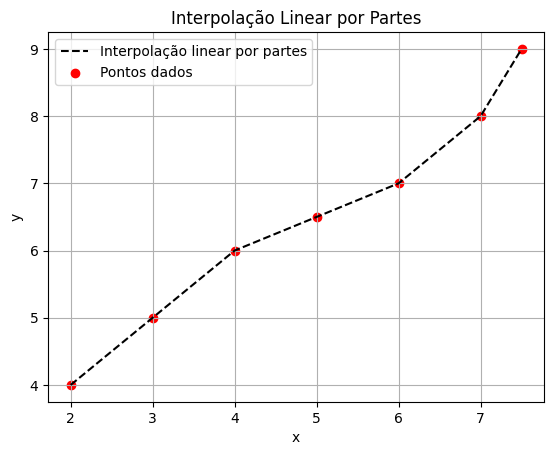

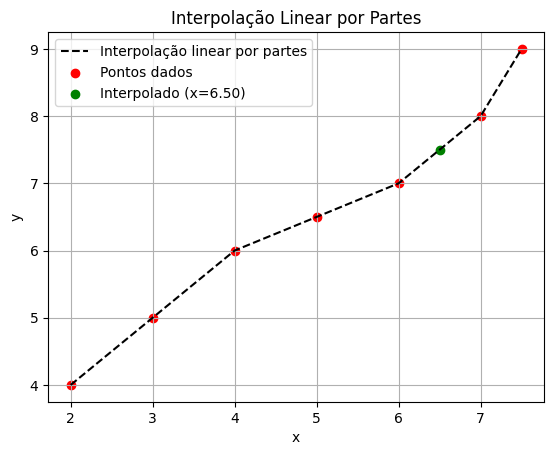

In [23]:
x_vals = [2, 3, 4, 6, 7.5, 5, 7]
y_vals = [4, 5, 6, 7, 9, 6.5, 8]

plot = plot_interpolacao_linear(x_vals, y_vals)

plot2 = plot_interpolacao_linear(x_vals, y_vals, 6.5)

## Interpolacao Hermite

In [24]:
class PolinomioHermite:
    def __init__(self, D: List[tuple[float, ...]]):
        """Inicializa o Polinômio Interpolador de Hermite.
        
        Args:
            D: Lista de tuplas estruturada como (x,f(x),f'(x),...,f^k(x)).

        Raises:
            ValueError: Se os dados não existem ou se não houver x e f(x) para todos os
                        pontos informados.
        """
        if not D or not all(len(d) > 1 for d in D):
            raise ValueError
            
        self.data = D
        self.condicoes = sum(len(d) - 1 for d in D)
        self.grau = self.condicoes - 1
        
        self.x = np.zeros(self.condicoes)
        self.y = np.zeros(self.condicoes) 
        self.derivadas = {}
        indice = 0
        for tupla in D:
            x = tupla[0]
            derivadas = len(tupla) - 1
            for i in range(derivadas):
                self.x[indice + i] = x #x
                self.y[indice + i] = tupla[1] #f(x)
                self.derivadas[(x, i)] = tupla[1 + i] #derivadas
            indice += derivadas
        self._coeficientes = self.newton()
        
    def newton(self) -> np.ndarray:
        """Calcula os coeficientes do polinômio de Hermite pelo método de Newton de
           diferenças divididas."""
        
        # tabela de diferenças divididas
        d = np.zeros((self.condicoes, self.condicoes))
        d[:, 0] = self.y 
        
        for i in range(1, self.condicoes):
            for j in range(self.condicoes - i):
                if self.x[j] != self.x[j+i]:
                    # Regra de Newton
                    d[j, i] = (d[j+1, i-1] - d[j, i-1]) / (self.x[j+i] - self.x[j])
                else:
                    # f^(i)(x)/i!
                    x = self.x[j]
                    derivada = self.derivadas.get((x, i), 0.0) 
                    d[j, i] = derivada / math.factorial(i)
        return d[0]
    
    @property
    def coeficientes(self) -> List[float]:
        return self._todos_coeficientes()
    
    @property
    def polinomio(self) -> str:
        return str(self._forma_padrao_simbolica())

    def __repr__(self) -> list[float]:
        return self._todos_coeficientes()

    def __str__(self) -> str:
        """Representa em string o polinômio interpolador na forma de Newton."""
        return str(self._forma_padrao_simbolica())

    def avaliar(self, x: float|int) -> float:
        """Avalia o polinômio interpolador para o valor x.
        
        Args:
            x: Valor a ser interpolado.

        Returns:
            float: Resultado de x no polinômio interpolador.

        Raises:
            ValueError: Se x não é do tipo numérico 
        """
        if len(self._coeficientes) == 0:
            return 0
        polinomio = self._coeficientes[0] # c_0
        for i in range(1, self.condicoes):
            termo = self._coeficientes[i] # c_i
            for j in range(i):
                termo *=(x-self.x[j])
            polinomio += termo
        return polinomio

    def _forma_padrao_simbolica(self) -> sp.Expr:
            """
            Calcula e retorna o polinômio na forma padrão (expandida)
            usando a biblioteca SymPy.
            """
            if len(self._coeficientes) == 0:
                return sp.Integer(0)

            x = sp.Symbol('x')
            poly = sp.Float(self._coeficientes[0])
            prod_term = 1
            
            for i in range(1, self.condicoes):
                # (x - z0) * (x - z1) * ... * (x - z_{i-1})
                prod_term *= (x - self.x[i - 1])
                # Adiciona c_i * produto
                poly += sp.Float(self._coeficientes[i]) * prod_term

            return sp.expand(poly)

    def _todos_coeficientes(self) -> list[float]:
        expressao = self._forma_padrao_simbolica()

        if expressao == sp.Integer(0) and self.grau >= 0:
            return [0.0] * (self.grau + 1)
        
        x = sp.Symbol('x')
        polinomio_obj = expressao.as_poly()

        coeficientes = polinomio_obj.all_coeffs()

        resultado = [float(coeficiente) for coeficiente in coeficientes]
        return resultado
        
    def __call__(self, x: float|int|List[float|int]|np.ndarray) -> float|list[float]:
        """Permite que o polinômio atue como uma função matemática com entrada x.
        
        Args:
            x: Valor(es) a ser(em) interpolado(s).

        Returns:
            Resultado de x no polinômio interpolador.

        Raises:
            ValueError: Se x não é do tipo numérico.
        """
        if isinstance(x, (float, int, np.float64, np.float32, np.int64, np.int32)):
            return self.avaliar(float(x)) 
        elif isinstance(x, (list, np.ndarray)):
            resultados = [self.avaliar(float(i)) for i in x]
            return resultados
        raise ValueError

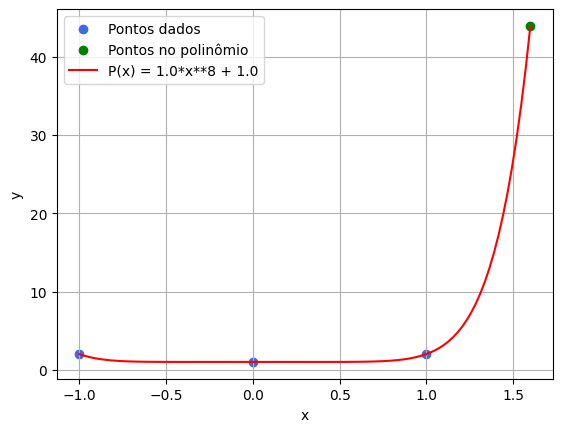

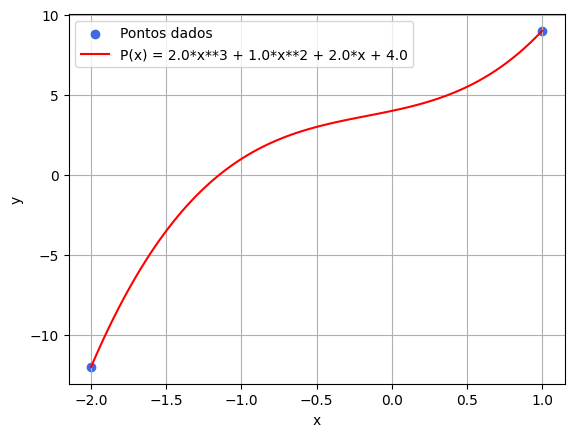

In [25]:
def plot_polinomioHermite(D, p=None):
    """Plota polinômio interpolador e pontos dados.

        O método plota o polinômio interpolador calculado pela classe PolinomioInterpolador
        e os pontos dos dados originais e, opcionalmente, novos pontos calculados pelo
        polinômio.
        
        Args:
            x: Coordenadas x dos pontos de interpolação. Pode ser uma lista ou array numpy.
            y: Coordenadas y dos pontos de interpolação. Pode ser uma lista ou array numpy.
            p: Coordenadas x dos novos pontos a serem plotados pelo polinômio interpolador.
    """
    polinomio = PolinomioHermite(D)
    dados = np.array([[x[0], x[1]] for x in D])

    # Plotar pontos originais
    plt.scatter(dados[:,0], dados[:,1], color='royalblue', label='Pontos dados')
    Min = min(dados[:,0])
    Max = max(dados[:,0])
    if p:
        plt.scatter(p, polinomio(p), color='green', label='Pontos no polinômio')
        if isinstance(p,(list,np.ndarray)):
            if min(p)<Min:
                Min=min(p)
            if max(p)>Max:
                Max=max(p)
        else:
            if p<Min:
                Min=p
            if p>Max:
                Max=p
    num_pts = 100
    X = np.linspace(Min, Max, num_pts)
    Y = np.polyval(polinomio.coeficientes, X)
    plt.plot(X, Y, '-r', label=f'P(x) = {polinomio}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemplos:
X1 = [(-1,2,-8,56),(0,1,0,0),(1,2,8,56)]
plot_polinomioHermite(X1, 1.6)
X2 = [(-2,-12,22),(1,9,10)]
plot_polinomioHermite(X2)

## Interpolação Polinomial

In [26]:
class PolinomioInterpolador:
    def __init__(self,x:List[float],y:List[float]):
        """Inicializa o polinômio interpolador de um dado conjuto de pontos.

        Args:
            x: Coordenadas x dos pontos ke interpolação. Pode ser uma lista ou array numpy.
            y: Coordenadas y dos pontos de interpolação. Pode ser uma lista ou array numpy.
        
        """
        self.x=np.array(x)
        self.y=np.array(y)

    def coeficientes(self) -> List[float]:
        """Calcula e retorna os coeficientes do polinômio interpolador de grau n-1.

        O método calcula os coeficientes do polinômio interpolador que passa pelos
        pontos (x,y) por meio da construção da matriz de Vandermonde V e resolvendo o
        sistema linear V.X=y.
        O polinômio resultante é P(t) = X[0] + X[1]*t + ... + X[n-1]*t^(n-1).

        Returns:
            np.array: Coeficientes do polinômio do grau 0 ao grau n-1.

        Raises:
            numpy.linalg.LinAlgError: Se a matriz de Vandermonde for singular
            ValueError: Se as listas x e y tiverem tamanhos diferentes.
        """
        matrizV = np.vander(self.x, increasing=True)
        X = np.linalg.solve(matrizV, self.y)
        return X

    def __str__(self) -> str:
        """Representa o polinômio interpolador em formato de string.

        Returns:
            str: Representação no formato a_0+a_1*x^1+...+a_n*x^n
        """
        X = self.coeficientes()
        if len(X)==0:
            return "0"
        polinomio = f"{X[0]:.10g}"
        for i in range(1,len(X)):
            polinomio="".join([polinomio,f"+{X[i]:.10g}*x^{i}"])
        return polinomio.replace("+-","+")
    
    def _lagrange(self,x:float|int|np.float64|np.float32|np.int64|np.int32):
        """Avalia o polinômio interpolador para o valor x pelo método de Lagrange.

        O método calcula o valor de y no ponto (x,y) no polinômio interpolador de
        Lagrange.
        
        Args:
            x: Valor a ser interpolado.

        Returns:
            float: Resultado de x no polinômio interpolador.

        Raises:
            ValueError: Se x não é do tipo numérico.
        """
        P=0
        for i in range(len(self.x)):
            p = 1
            for j in range(len(self.x)):
                if i!=j:
                    p*=(x-self.x[j])/(self.x[i]-self.x[j])
            P+=p*self.y[i]
        return P
    
    def __call__(self, x):
        """Permite que o polinômio atue como uma função matemática com entrada x.
        
        Args:
            x: Valor(es) a ser(em) interpolado(s).

        Returns:
            Resultado de x no polinômio interpolador.

        Raises:
            ValueError: Se x não é do tipo numérico.
        """
        if isinstance(x,(float, int, np.float64, np.float32, np.int64, np.int32)):
            return self._lagrange(x)
        elif isinstance(x,(List,np.ndarray)):
            resultados = []
            for i in x:
                resultados.append(self._lagrange(i))
            return resultados
        raise ValueError
    
    '''def add(self,x,y):
        """Atualiza o polinômio interpolador com a adição de pontos"""

    def remove(self,x):
        """Atualiza o polinômio interpolador com a remoção de pontos"""'''

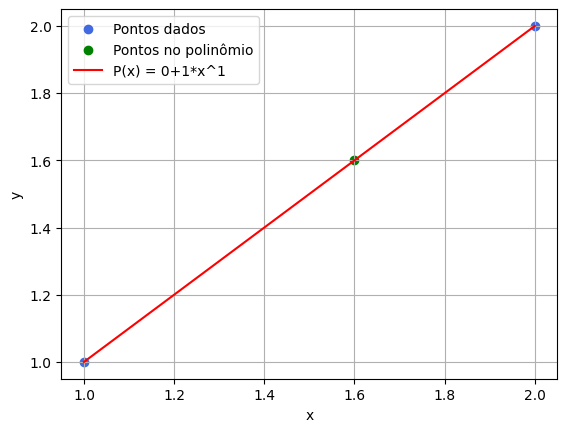

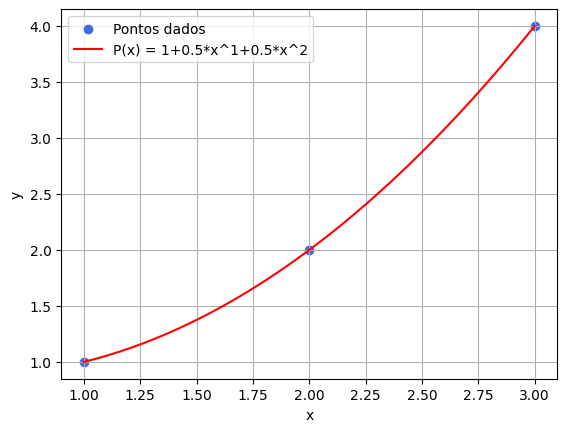

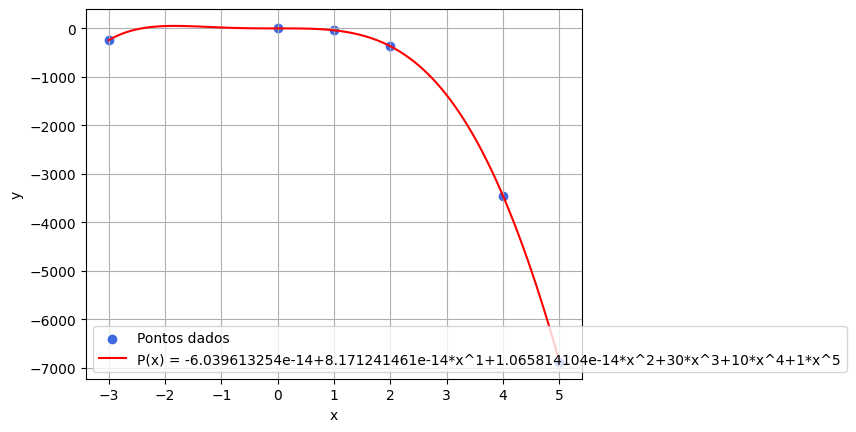

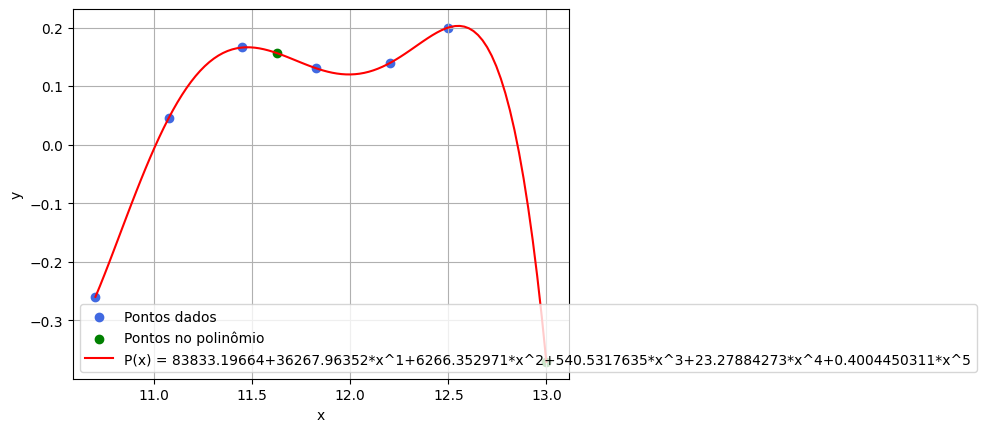

In [27]:
def plot_polinomioInterpolador(x, y, p=None):
    """Plota polinômio interpolador e pontos dados.

        O método plota o polinômio interpolador calculado pela classe PolinomioInterpolador
        e os pontos dos dados originais e, opcionalmente, novos pontos calculados pelo
        polinômio.
        
        Args:
            x: Coordenadas x dos pontos de interpolação. Pode ser uma lista ou array numpy.
            y: Coordenadas y dos pontos de interpolação. Pode ser uma lista ou array numpy.
            p: Coordenadas x dos novos pontos a serem plotados pelo polinômio interpolador.
    """
    polinomio = PolinomioInterpolador(x, y)

    plt.scatter(x, y, color='royalblue', label='Pontos dados')
    Min = min(x)
    Max = max(x)
    if p:
        plt.scatter(p, polinomio(p), color='green', label='Pontos no polinômio')
        if isinstance(p,(list,np.ndarray)):
            if min(p)<Min:
                Min=min(p)
            if max(p)>Max:
                Max=max(p)
        else:
            if p<Min:
                Min=p
            if p>Max:
                Max=p
    num_pts = 100
    X = np.linspace(Min, Max, num_pts)
    coeficientes = polinomio.coeficientes()[::-1]
    Y = np.polyval(coeficientes, X)
    plt.plot(X, Y, '-r', label=f'P(x) = {polinomio}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemplos:
X1 = [1,2]
Y1 = [1,2]
plot_polinomioInterpolador(X1, Y1, 1.6)

X2 = [1,2,3]
Y2 = [1,2,4]
plot_polinomioInterpolador(X2, Y2)

X3 = [1,2,-3,4,5,0]
Y3 = [-39,-368,-243,-3456,-6875,0]
plot_polinomioInterpolador(X3, Y3)

DataX = [10.7, 11.075, 11.45, 11.825, 12.2, 12.5]
DataY = [-0.25991903,  0.04625002,  0.16592075,  0.13048074,  0.13902777, 0.2]
plot_polinomioInterpolador(DataX, DataY,[11.625, 13])